In [2]:
import os
import re
import random
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

In [3]:
!wget -O syllables.txt 'https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/Syllable_dictionary.txt'

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.
            
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = np.array(A)
        self.O = np.array(O)
        self.A_start = np.array([1. / self.L for _ in range(self.L)])


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        
        # probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # seqs[i][j] represents the state that produced the max prob for probs[i][j]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        # update with initial probabilities
        # initial state labels
        for i in range(self.L):
          probs[1][i] = self.A_start[i] * self.O[i][x[0]]
          seqs[1][i] = str(i)

        # filling in table
        for row in range(2, M+1):
          for col in range(self.L):
            max_prob = -1
            max_prefix = ''
            for i in range(self.L):
              prob = probs[row-1][i] * self.A[i][col] * self.O[col][x[row-1]]
              prefix = seqs[row-1][i] + str(col)
              # only keep the max prob and its prefix
              if prob > max_prob:
                max_prob = prob
                max_prefix = prefix
            probs[row][col] = max_prob
            seqs[row][col] = max_prefix
            
        return seqs[-1][np.argmax(probs[-1])]


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)  # length of sequence

        # Compute forward probabilities
        alphas = np.zeros((M + 1, self.L))
        # alphas 1 indexed; x is 0 indexed
        alphas[1] = self.O[:, x[0]] * self.A_start

        for row in range(2, M+1):
          for col in range(self.L):
            alphas[row][col] = self.O[col][x[row-1]] * np.sum(alphas[row-1,:] * 
                                                              self.A[:,col])
            
          if normalize:
            norm = np.sum(alphas[row])
            alphas[row] = [i/norm for i in alphas[row]]

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = np.zeros((M+1, self.L))

        betas[M] = np.ones(self.L)

        for row in range(M-1, 0, -1):
          for col in range(self.L):
            betas[row][col] = np.sum(betas[row+1,:] * self.A[col,:] * 
                               self.O[:,x[row]])
            
          if normalize:
            norm = np.sum(betas[row])
            betas[row] = [i/norm for i in betas[row]]

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        # y^{i+1}_j = a | y^i_j = b

        for b in range(self.L):
          for a in range(self.L):
            numerator = 0
            denominator = 0
            for j in range(len(X)):
              for i in range(len(X[j])-1):
                if Y[j][i] == b:
                  denominator += 1
                  if Y[j][i+1] == a:
                    numerator += 1
            self.A[b][a] = numerator/denominator

        # Calculate each element of O using the M-step formulas.
        # x^i_j = w | y^i_j = z

        for z in range(self.L):
          for w in range(self.D):
            numerator = 0
            denominator = 0
            for j in range(len(X)):
              for i in range(len(X[j])-1):
                if Y[j][i] == z:
                  denominator += 1
                  if X[j][i] == w:
                    numerator += 1
            self.O[z][w] = numerator/denominator


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            N_iters:    The number of iterations to train on.
        '''

        for _ in tqdm(range(N_iters)):

          Anumerator = np.zeros(shape=(self.L, self.L))
          Adenominator = np.zeros(shape=(self.L, self.L))
          Onumerator = np.zeros(shape=(self.L, self.D))
          Odenominator = np.zeros(shape=(self.L, self.D))

          for x in X:
              M = len(x)
              alphas = self.forward(x, normalize=True)
              betas = self.backward(x, normalize=True)

              # equation 6 "gamma"
              margprob1 = alphas * betas
              for i in range(1, M+1):
                margprob1[i] /= np.sum(margprob1[i]) # by rows

              # equation 7 "xi"
              margprob2 = np.zeros(shape=(M, self.L, self.L))
              for i in range(1, M):
                for a in range(self.L):
                  for b in range(self.L):
                    margprob2[i][a][b] = alphas[i][a] * self.O[b][x[i]] * self.A[a][b] * betas[i+1][b]
                margprob2[i] /= np.sum(margprob2[i]) # by rows

              # updating using gamma
              for k in range(1, M+1):
                for i in range(self.L):
                  Onumerator[i][x[k-1]] += margprob1[k][i] 
                  Odenominator[i] += margprob1[k][i]
                  Adenominator[i] += margprob1[k-1][i]

              for k in range(1, M):
                for i in range(self.L):
                  for j in range(self.L):
                    Anumerator[i][j] += margprob2[k][i][j]

          self.A = Anumerator/Adenominator
          self.O = Onumerator/Odenominator


    def generate_emission(self, M, seed=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''
        
        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        # starting state is chosen uniformly at random
        start = rng.choice(range(self.L))
        # states.append(start)
        curr_state = start

        for i in range(M):
          curr_emission = rng.choice(range(self.D), p=self.O[curr_state])
          emission.append(curr_emission)

          next_state = rng.choice(range(self.L), p=self.A[curr_state])
          states.append(next_state)

          curr_state = next_state

        return emission, states


    def generate_emission_with_rhyme(self, rhyme, obs_map, syllable_dict, syllables=10, seed=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''
        obs_map_r = obs_map_reverser(obs_map)

        rhyme_syllables = syllable_dict[rhyme]
        if type(rhyme_syllables) != int:
          if type(rhyme_syllables[0]) != int:
            rhyme_syllables = int(rhyme_syllables[0][1:])
          else:
            rhyme_syllables = int(rhyme_syllables[np.random.choice(range(len(rhyme_syllables)))])

        rng = np.random.default_rng(seed=seed)

        # find most likely state for the ending rhyme word
        for i, prob in enumerate(self.O[:, obs_map[rhyme]]):
          largest_state = -1
          largest_prob = -1
          if prob > largest_prob:
            largest_prob = prob
            largest_state = i
          
        emission = [obs_map[rhyme]]
        states = [largest_state]

        curr_syllables = rhyme_syllables
        curr_state = largest_state

        while curr_syllables < syllables:
          # generate the emission sentence here
          curr_emission = rng.choice(range(self.D), p=self.O[curr_state])

          next_state = rng.choice(range(self.L), p=(self.A.T[curr_state]/sum(self.A.T[curr_state])))

          curr_state = next_state

          word_syllables = syllable_dict[obs_map_r[curr_emission]]
          if type(word_syllables) != int:
            if type(word_syllables[0]) != int:
              word_syllables = int(word_syllables[1])
            else:
              word_syllables = int(word_syllables[np.random.choice(range(len(word_syllables)))])

          if curr_syllables + word_syllables <= syllables:
            curr_syllables += word_syllables

            emission.append(curr_emission)
            states.append(next_state)

        return emission


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters, seed=None):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''
    # Initialize random number generator
    rng = np.random.default_rng(seed=seed)

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM


########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 HMM helper
########################################

import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    apostrophe = ["'gainst", "'greeing", "'scaped", "'tis", "'twixt"]
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
          if len(line) != 1:
            word = re.sub(r"(?<!\w')[^\w'-]+|[^\w'-]+(?='\w)", "", word).lower()
            while word[0].isalpha() == False:
              if word not in apostrophe:
                word = word[1:]
              else:
                break
            while word[-1].isalpha() == False:
              if word != "th'":
                word = word[:-1]
              else:
                break
          if word not in obs_map:
              # Add unique words to the observations map.
              obs_map[word] = obs_counter
              obs_counter += 1
          
          # Add the encoded word.
          obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words, seed=seed)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'

Preprocessing data into sonnets

In [5]:
text = urllib.request.urlopen('https://raw.githubusercontent.com/emiletimothy/Caltech-CS155-2023/main/miniproject3/data/shakespeare.txt').read().decode('utf-8')
modified = text.replace("                   ", "")
modified = re.sub(r'\d+\n', '', modified)
obs, obs_map = parse_observations(modified)

shakespeare = [i for i in text.split("\n") if i != '']
shakespeare.pop(0)

sonnets = []
curr = []
for line in shakespeare:
  if line.startswith('                   '):
    if len(curr) == 14:
      sonnets.append(curr)
    curr = []
  else:
    curr.append(line)


Generating the syllable dictionary

In [6]:
syllable_dict = {}

with open("syllables.txt") as f:
  for line in f:
    word, syllables = line.strip().split(maxsplit=1)
    if len(syllables) > 1:
      syllables = syllables.split()
      for i, v in enumerate(syllables):
        if v.isnumeric():
          syllables[i] = int(v)
      if type(syllables[1]) != int:
        end = syllables.pop(1)
        syllables.insert(0, end)
      syllable_dict[word] = syllables
    if len(syllables) == 1:
      syllable_dict[word] = int(syllables)

Generating rhyming pairs from sonnets

In [7]:
# finding rhyming words
rhymes = [(1, 3), (2, 4), (5, 7), (6, 8), (9, 11), (10, 12), (13, 14)]
rhymepairs = []

for sonnet in sonnets:
  if (len(sonnet) != 14):
    print(sonnet)
  for r1, r2 in rhymes:
    line1 = sonnet[r1-1].split(" ")
    line2 = sonnet[r2-1].split(" ")
    
    rhyme1 = (line1[-1] if line1[-1].isalpha() else line1[-1][0:-1])
    rhyme2 = (line2[-1] if line2[-1].isalpha() else line2[-1][0:-1])

    rhymepairs.append((rhyme1, rhyme2))

In [11]:
hmm = unsupervised_HMM(obs, 30, 100)

100%|██████████| 100/100 [1:22:32<00:00, 49.52s/it]


Generating sample sonnet

In [15]:
def sample_sentence_rhyme(hmm, obs_map, rhyme, syllable_dict, syllables, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission = hmm.generate_emission_with_rhyme(rhyme, obs_map, syllable_dict, 10, seed)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence[::-1]).capitalize()

In [13]:
def sample_sonnet(hmm, obs_map, rhymepairs, syllable_dict, seed=None):
  obs_map_r = obs_map_reverser(obs_map)
  sonnet = []

  for _ in range(3): # 3 quatrains
    rhyme1, rhyme3 = rhymepairs[np.random.randint(len(rhymepairs))]
    rhyme2, rhyme4 = rhymepairs[np.random.randint(len(rhymepairs))]
    sonnet.append(sample_sentence_rhyme(hmm, obs_map, rhyme1, syllable_dict, 10))
    sonnet.append(sample_sentence_rhyme(hmm, obs_map, rhyme2, syllable_dict, 10))
    sonnet.append(sample_sentence_rhyme(hmm, obs_map, rhyme3, syllable_dict, 10))
    sonnet.append(sample_sentence_rhyme(hmm, obs_map, rhyme4, syllable_dict, 10))

  rhyme13, rhyme14 = rhymepairs[np.random.randint(len(rhymepairs))]
  sonnet.append(sample_sentence_rhyme(hmm, obs_map, rhyme13, syllable_dict, 10))
  sonnet.append(sample_sentence_rhyme(hmm, obs_map, rhyme14, syllable_dict, 10))

  return sonnet

In [17]:
sample_sonnet(hmm, obs_map, rhymepairs, syllable_dict)

['The flesh praise it edge then these to and shine',
 "Fall there i mayst and thou have lies love's old",
 'That prouder love mine all far thee and mine',
 'Then nor we have one to them making told',
 'When my thought is this spent and truth which up',
 'Rider shall point as sun and worse for pluck',
 'Well by was she never in thee and cup',
 'The more oaths of sheaves which within so luck',
 'Into my nurse discloses scorn which east',
 'Gave consumed and they and all doth can stand',
 'Doom hath sweets and the spent far all and west',
 "Not as pride to on men's to-morrow land",
 'Kind from a which still in mouthed knows shines',
 'The at at thy love on belongs declines']

In [23]:
def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1, seed=None):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M, seed=seed)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim


Animating...


RuntimeError: Requested MovieWriter (ffmpeg) not available

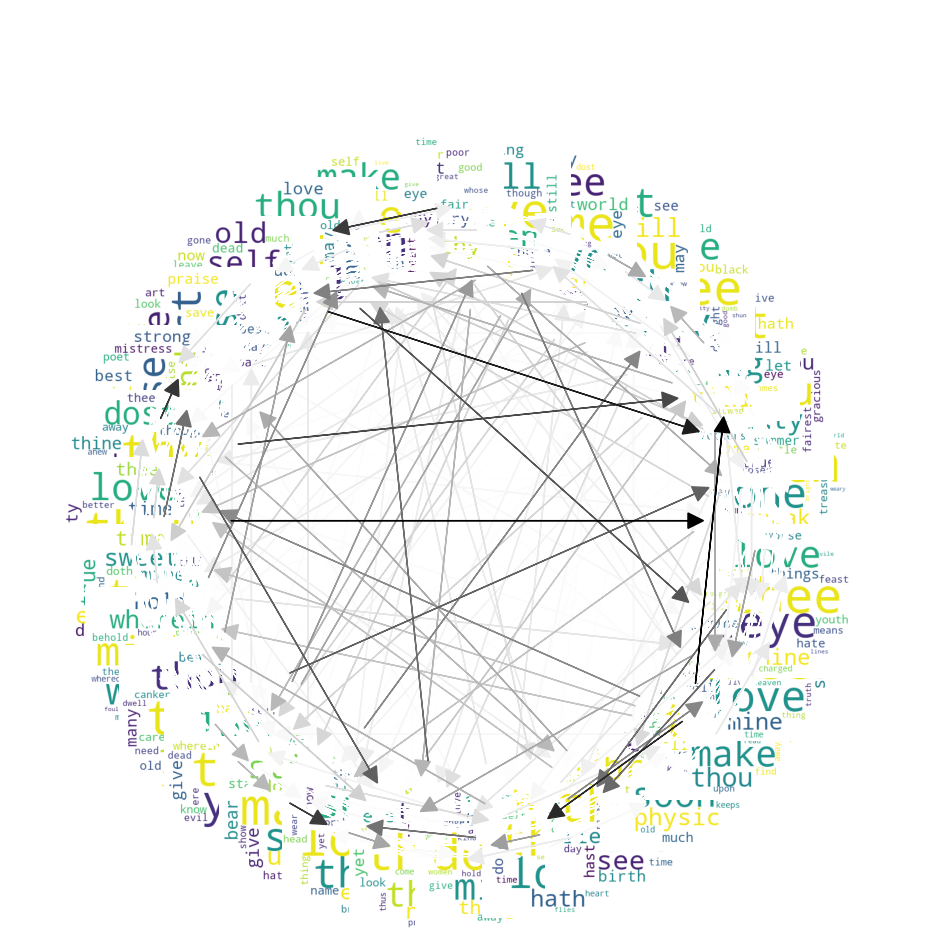

In [24]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation
anim = animate_emission(hmm, obs_map, M=8, seed=1)
HTML(anim.to_html5_video())